# Dependencies

In [1]:
!pip install tensorflow
!pip install keras
!pip install nltk
!pip install vaderSentiment
!pip install category_encoders
!pip install spacy
!pip install spacytextblob
!pip install wordcloud

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout, Embedding, LSTM, Bidirectional, GRU
from keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.sequence import pad_sequences
import nltk
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from category_encoders import OrdinalEncoder
import spacy
from spacytextblob.spacytextblob import SpacyTextBlob
import numpy as np
from wordcloud import WordCloud
%run -m textblob.download_corpora
%run -m spacy download en_core_web_sm

nltk.download('wordnet')

[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package conll2000 to /root/nltk_data...
[nltk_data]   Package conll2000 is already up-to-date!
[nltk_data] Downloading package movie_reviews to /root/nltk_data...
[nltk_data]   Package movie_reviews is already up-to-date!


Finished.
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [3]:
def evaluate(model, X, y, dataset="Testing"):
    loss, acc = model.evaluate(X, y, verbose=1)
    print('%s Accuracy: %.3f' % (dataset, acc))
    print('%s Loss: %.3f' % (dataset, loss))

In [4]:
def inference(model, X):
  predictions = model.predict(X)
  predictions = pd.Series(np.argmax(predictions, axis=1), name="Prediction")

  return pd.DataFrame(predictions)

# BiLSTM, Textblob Labeling, 80/10/10 Dataset

## Load Data & EDA

In [5]:
comment_df = pd.read_csv('sentiment_analysis.csv')
comment_df

,comment,sentiment
0,dear ed sheeran,Neutral
1,the only person she wanted to talk about augus...,Neutral
2,thanks for being part of the tfios movie ed be...,Positive
3,im surprised that this song isnt high up there...,Positive
4,you gave me forever within the numbered days,Neutral
...,...,...
19422,the video was shot in kyiv which is now being ...,Neutral
19423,sorryineedtogogetthingdonemissyouverymuchjusth...,Neutral
19424,andy get excited elon got more robots for us s...,Positive
19425,im in relationship ofdas and imany advice,Neutral


In [6]:
comments = comment_df["comment"]

comments

,comment
0,dear ed sheeran
1,the only person she wanted to talk about augus...
2,thanks for being part of the tfios movie ed be...
3,im surprised that this song isnt high up there...
4,you gave me forever within the numbered days
...,...
19422,the video was shot in kyiv which is now being ...
19423,sorryineedtogogetthingdonemissyouverymuchjusth...
19424,andy get excited elon got more robots for us s...
19425,im in relationship ofdas and imany advice


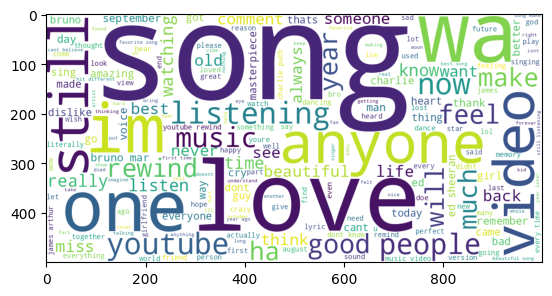

In [7]:
doc = []
stemmer = WordNetLemmatizer()
for comment in comments:

    # Lemmatization
    document = comment.split()
    document = [stemmer.lemmatize(word) for word in document]
    doc.extend(document)

wordcloud = " ".join(doc)
wordcloud = WordCloud(width = 1000, height = 500,background_color ='white',min_font_size = 10).generate(wordcloud)
plt.imshow(wordcloud)

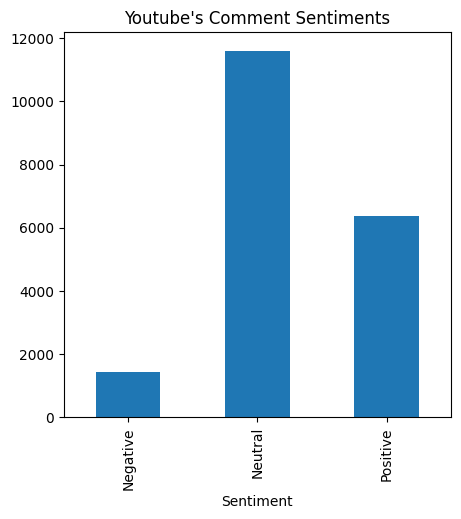

In [8]:
ax = comment_df["sentiment"].value_counts().sort_index() \
    .plot(kind='bar',
          title='Youtube\'s Comment Sentiments',
          figsize=(5, 5))
ax.set_xlabel('Sentiment')
plt.show()

## Preprocessing Data

In [9]:
enc_maps = {
    "sentiment" : [{'col': "sentiment", 'mapping': {"Positive": 2, "Neutral": 1, "Negative": 0}}],
}

enc_map = enc_maps["sentiment"]
enc = OrdinalEncoder(mapping=enc_map)
comment_df = enc.fit_transform(comment_df)

labels = comment_df["sentiment"]
pd.DataFrame(labels)

,sentiment
0,1
1,1
2,2
3,2
4,1
...,...
19422,1
19423,1
19424,2
19425,1


In [10]:
doc = []
stemmer = WordNetLemmatizer()
for comment in comments:

    # Lemmatization
    document = comment.split()
    document = [stemmer.lemmatize(word) for word in document]
    document = ' '.join(document)
    doc.append(document)

doc

['dear ed sheeran',
 'the only person she wanted to talk about augustus water death wa augustus watersthis line made me cry',
 'thanks for being part of the tfios movie ed beautiful song john',
 'im surprised that this song isnt high up there this song is amazing',
 'you gave me forever within the numbered day',
 'the fault in our star is one of the most beautiful book ive ever read and this song is one of the most beautiful song ive ever heard',
 'am the only one who cry cause hell this song is beautiful',
 'my heart ache every time listen to this song',
 'this song make me cry so much the video just make me miss gu even more',
 'everything about the fault in our star is touching the book the film the song thank john green for this',
 'im cying over someone havent even met yet thats how powerful this song is',
 'dear stranger you have great taste in music see you again afteryrs',
 'hope everyone who read this comment get little infinity of their own somedayits the most we can hope for

In [11]:
# Use only Tokenizer for consistent text processing
tokenizer = Tokenizer(num_words=10000, oov_token='<OOV>')
tokenizer.fit_on_texts(doc)
sequences = tokenizer.texts_to_sequences(doc)

sequences

[[457, 70, 150],
 [3,
  85,
  183,
  74,
  343,
  5,
  324,
  79,
  1993,
  828,
  811,
  19,
  1993,
  4889,
  506,
  122,
  13,
  111],
 [306, 18, 241, 187, 12, 3, 1300, 359, 70, 69, 4, 954],
 [23, 1006, 15, 2, 4, 271, 519, 95, 91, 2, 4, 6, 136],
 [11, 400, 13, 252, 1489, 3, 3416, 77],
 [3,
  614,
  9,
  163,
  234,
  6,
  27,
  12,
  3,
  104,
  69,
  592,
  152,
  99,
  344,
  7,
  2,
  4,
  6,
  27,
  12,
  3,
  104,
  69,
  4,
  152,
  99,
  160],
 [98, 3, 85, 27, 16, 111, 315, 511, 2, 4, 6, 69],
 [10, 102, 1237, 87, 41, 78, 5, 2, 4],
 [2, 4, 59, 13, 111, 17, 66, 3, 33, 22, 59, 13, 94, 3417, 100, 108],
 [195,
  79,
  3,
  614,
  9,
  163,
  234,
  6,
  646,
  3,
  592,
  3,
  955,
  3,
  4,
  169,
  954,
  1618,
  18,
  2],
 [23, 4890, 179, 97, 464, 100, 410, 403, 157, 39, 751, 2, 4, 6],
 [457, 1161, 11, 42, 139, 498, 9, 48, 81, 11, 127, 2731],
 [175,
  153,
  16,
  344,
  2,
  89,
  65,
  284,
  1769,
  12,
  184,
  373,
  4891,
  3,
  104,
  37,
  46,
  175,
  18,
  9,
  2,
  1

In [12]:
# Pad sequences to ensure consistent input length
max_length = 200
X = pad_sequences(sequences, maxlen=max_length, padding='post', truncating='post')
X

array([[457,  70, 150, ...,   0,   0,   0],
       [  3,  85, 183, ...,   0,   0,   0],
       [306,  18, 241, ...,   0,   0,   0],
       ...,
       [  1,  65, 934, ...,   0,   0,   0],
       [ 23,   9, 366, ...,   0,   0,   0],
       [ 85,  62,  74, ...,   0,   0,   0]], dtype=int32)

## Data Splitting

In [13]:
# Split data (training: 80%, validation: 10%, testing: 10%)
X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size=0.1, random_state=40)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.11, random_state=40)

## Modelling

In [14]:
vocab_size = len(tokenizer.word_index) + 1 # melihat ukuran vocabulary
embedding_vector_length = 128

print(vocab_size)

13401


In [15]:
# BiLSTM Model

opt = tf.keras.optimizers.Adam(learning_rate=0.001, weight_decay=1e-4)
early_stopping = EarlyStopping(
    monitor="val_accuracy",
    min_delta=0,
    patience=0,
    verbose=0,
    mode="max",
    baseline=0.93,
    restore_best_weights=True,
    start_from_epoch=0,
)
model = Sequential()
model.add(Embedding(vocab_size, embedding_vector_length, input_length=max_length))
model.add(Dropout(0.5))
model.add(Bidirectional(LSTM(128)))
model.add(Dense(128, activation='tanh'))
model.add(Dropout(0.5))
model.add(Dense(3, activation='softmax'))

model.compile(optimizer=opt, metrics=['accuracy'], loss='sparse_categorical_crossentropy')

model.build(input_shape=(None, max_length))
model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 200, 128)       │     1,715,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 200, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 256)            │       263,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,011,779 (7.67 MB)

 Trainable params: 2,011,779 (7.67 MB)

 Non-trainable params: 0 (0.00 B)

In [16]:
# Training
history = model.fit(X_train, y_train, epochs=50, validation_data=(X_val, y_val), callbacks=[early_stopping])

Epoch 1/50
487/487 ━━━━━━━━━━━━━━━━━━━━ 247s 502ms/step - accuracy: 0.6849 - loss: 0.7231 - val_accuracy: 0.8940 - val_loss: 0.3094
Epoch 2/50
487/487 ━━━━━━━━━━━━━━━━━━━━ 208s 428ms/step - accuracy: 0.9012 - loss: 0.2737 - val_accuracy: 0.9252 - val_loss: 0.2321
Epoch 3/50
487/487 ━━━━━━━━━━━━━━━━━━━━ 263s 430ms/step - accuracy: 0.9458 - loss: 0.1558 - val_accuracy: 0.9330 - val_loss: 0.2150
Epoch 4/50
487/487 ━━━━━━━━━━━━━━━━━━━━ 208s 427ms/step - accuracy: 0.9622 - loss: 0.1066 - val_accuracy: 0.9272 - val_loss: 0.2108


## Evaluation

In [17]:
print("BiLSTM, Textblob Labeling, 80/10/10 Dataset")
evaluate(model, X_train, y_train, "Training")
evaluate(model, X_val, y_val, "Validation")
evaluate(model, X_test, y_test, "Testing")

BiLSTM, Textblob Labeling, 80/10/10 Dataset
487/487 ━━━━━━━━━━━━━━━━━━━━ 73s 150ms/step - accuracy: 0.9665 - loss: 0.0974
Training Accuracy: 0.967
Training Loss: 0.096
61/61 ━━━━━━━━━━━━━━━━━━━━ 6s 91ms/step - accuracy: 0.9322 - loss: 0.2113
Validation Accuracy: 0.933
Validation Loss: 0.215
61/61 ━━━━━━━━━━━━━━━━━━━━ 6s 102ms/step - accuracy: 0.9159 - loss: 0.2566
Testing Accuracy: 0.923
Testing Loss: 0.230


In [18]:
inference(model, X_test)

61/61 ━━━━━━━━━━━━━━━━━━━━ 7s 105ms/step


,Actual,Prediction
0,1,1
1,2,2
2,1,1
3,1,1
4,1,1
...,...,...
1938,1,1
1939,1,1
1940,1,2
1941,1,1


# BiLSTM, vaderSentiment Labeling, 60/20/20 Dataset

## Load Data & EDA

In [19]:
comment_df2 = pd.read_csv('sentiment_analysis.csv')
comment_df2

,comment,sentiment
0,dear ed sheeran,Neutral
1,the only person she wanted to talk about augus...,Neutral
2,thanks for being part of the tfios movie ed be...,Positive
3,im surprised that this song isnt high up there...,Positive
4,you gave me forever within the numbered days,Neutral
...,...,...
19422,the video was shot in kyiv which is now being ...,Neutral
19423,sorryineedtogogetthingdonemissyouverymuchjusth...,Neutral
19424,andy get excited elon got more robots for us s...,Positive
19425,im in relationship ofdas and imany advice,Neutral


In [20]:
comments = comment_df2["comment"]
comments

,comment
0,dear ed sheeran
1,the only person she wanted to talk about augus...
2,thanks for being part of the tfios movie ed be...
3,im surprised that this song isnt high up there...
4,you gave me forever within the numbered days
...,...
19422,the video was shot in kyiv which is now being ...
19423,sorryineedtogogetthingdonemissyouverymuchjusth...
19424,andy get excited elon got more robots for us s...
19425,im in relationship ofdas and imany advice


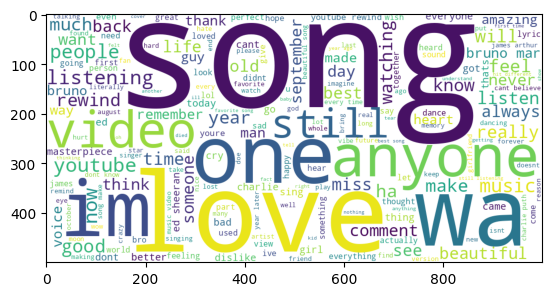

In [21]:
doc = []
stemmer = WordNetLemmatizer()
for comment in comments:

    # Lemmatization
    document = comment.split()
    document = [stemmer.lemmatize(word) for word in document]
    doc.extend(document)

wordcloud = " ".join(doc)
wordcloud = WordCloud(width = 1000, height = 500,background_color ='white',min_font_size = 10).generate(wordcloud)
plt.imshow(wordcloud)

In [22]:
analyzer = SentimentIntensityAnalyzer()

def sentiment_analysis(comment):
  vs = analyzer.polarity_scores(comment)
  max_value = max(vs["neg"], vs["neu"], vs["pos"])
  return "Positive" if max_value == vs["pos"] else ("Negative" if max_value == vs["neg"] else "Neutral")

comment_df2['sentiment'] = comment_df2['comment'].apply(lambda x: sentiment_analysis(x))
comment_df2['sentiment']

,sentiment
0,Positive
1,Neutral
2,Neutral
3,Neutral
4,Neutral
...,...
19422,Neutral
19423,Neutral
19424,Neutral
19425,Neutral


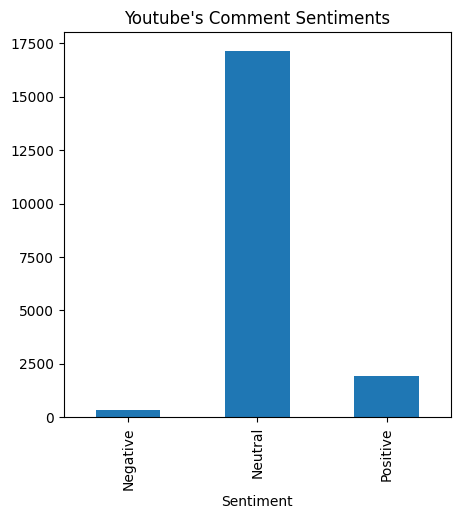

In [23]:
ax = comment_df2["sentiment"].value_counts().sort_index() \
    .plot(kind='bar',
          title='Youtube\'s Comment Sentiments',
          figsize=(5, 5))
ax.set_xlabel('Sentiment')
plt.show()

## Preprocessing Data

In [24]:
enc_maps = {
    "sentiment" : [{'col': "sentiment", 'mapping': {"Positive": 2, "Neutral": 1, "Negative": 0}}],
}


enc_map = enc_maps["sentiment"]
enc = OrdinalEncoder(mapping=enc_map)
comment_df2 = enc.fit_transform(comment_df2)

sentiments = comment_df2["sentiment"]
sentiments

,sentiment
0,2
1,1
2,1
3,1
4,1
...,...
19422,1
19423,1
19424,1
19425,1


In [25]:
doc = []
stemmer = WordNetLemmatizer()
for comment in comments:

    # Lemmatization
    document = comment.split()
    document = [stemmer.lemmatize(word) for word in document]
    document = ' '.join(document)
    doc.append(document)

doc

['dear ed sheeran',
 'the only person she wanted to talk about augustus water death wa augustus watersthis line made me cry',
 'thanks for being part of the tfios movie ed beautiful song john',
 'im surprised that this song isnt high up there this song is amazing',
 'you gave me forever within the numbered day',
 'the fault in our star is one of the most beautiful book ive ever read and this song is one of the most beautiful song ive ever heard',
 'am the only one who cry cause hell this song is beautiful',
 'my heart ache every time listen to this song',
 'this song make me cry so much the video just make me miss gu even more',
 'everything about the fault in our star is touching the book the film the song thank john green for this',
 'im cying over someone havent even met yet thats how powerful this song is',
 'dear stranger you have great taste in music see you again afteryrs',
 'hope everyone who read this comment get little infinity of their own somedayits the most we can hope for

In [26]:
# Use only Tokenizer for consistent text processing
tokenizer = Tokenizer(num_words=10000, oov_token='<OOV>')
tokenizer.fit_on_texts(doc)
sequences = tokenizer.texts_to_sequences(doc)

sequences

[[457, 70, 150],
 [3,
  85,
  183,
  74,
  343,
  5,
  324,
  79,
  1993,
  828,
  811,
  19,
  1993,
  4889,
  506,
  122,
  13,
  111],
 [306, 18, 241, 187, 12, 3, 1300, 359, 70, 69, 4, 954],
 [23, 1006, 15, 2, 4, 271, 519, 95, 91, 2, 4, 6, 136],
 [11, 400, 13, 252, 1489, 3, 3416, 77],
 [3,
  614,
  9,
  163,
  234,
  6,
  27,
  12,
  3,
  104,
  69,
  592,
  152,
  99,
  344,
  7,
  2,
  4,
  6,
  27,
  12,
  3,
  104,
  69,
  4,
  152,
  99,
  160],
 [98, 3, 85, 27, 16, 111, 315, 511, 2, 4, 6, 69],
 [10, 102, 1237, 87, 41, 78, 5, 2, 4],
 [2, 4, 59, 13, 111, 17, 66, 3, 33, 22, 59, 13, 94, 3417, 100, 108],
 [195,
  79,
  3,
  614,
  9,
  163,
  234,
  6,
  646,
  3,
  592,
  3,
  955,
  3,
  4,
  169,
  954,
  1618,
  18,
  2],
 [23, 4890, 179, 97, 464, 100, 410, 403, 157, 39, 751, 2, 4, 6],
 [457, 1161, 11, 42, 139, 498, 9, 48, 81, 11, 127, 2731],
 [175,
  153,
  16,
  344,
  2,
  89,
  65,
  284,
  1769,
  12,
  184,
  373,
  4891,
  3,
  104,
  37,
  46,
  175,
  18,
  9,
  2,
  1

In [27]:
# Pad sequences to ensure consistent input length
max_length = 200
X = pad_sequences(sequences, maxlen=max_length, padding='post', truncating='post')
X

array([[457,  70, 150, ...,   0,   0,   0],
       [  3,  85, 183, ...,   0,   0,   0],
       [306,  18, 241, ...,   0,   0,   0],
       ...,
       [  1,  65, 934, ...,   0,   0,   0],
       [ 23,   9, 366, ...,   0,   0,   0],
       [ 85,  62,  74, ...,   0,   0,   0]], dtype=int32)

## Data Splitting

In [28]:
# Split data (training: 60%, validation: 20%, testing: 20%)
X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size=0.2, random_state=40)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=40)

## Modelling

In [29]:
vocab_size = len(tokenizer.word_index) + 1 # melihat ukuran vocabulary
embedding_vector_length = 128

print(vocab_size)

13401


In [30]:
# BiLSTM Model

opt = tf.keras.optimizers.Adam(learning_rate=0.001, weight_decay=1e-4)
early_stopping = EarlyStopping(
    monitor="val_accuracy",
    min_delta=0,
    patience=0,
    verbose=0,
    mode="max",
    baseline=0.87,
    restore_best_weights=True,
    start_from_epoch=0,
)
model = Sequential()
model.add(Embedding(vocab_size, embedding_vector_length, input_length=max_length))
model.add(Dropout(0.5))
model.add(Bidirectional(LSTM(128)))
model.add(Dense(128, activation='tanh'))
model.add(Dropout(0.5))
model.add(Dense(3, activation='softmax'))

model.compile(optimizer=opt, metrics=['accuracy'], loss='sparse_categorical_crossentropy')

model.build(input_shape=(None, max_length))
model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, 200, 128)       │     1,715,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 200, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 256)            │       263,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,011,779 (7.67 MB)

 Trainable params: 2,011,779 (7.67 MB)

 Non-trainable params: 0 (0.00 B)

In [31]:
# Training
history = model.fit(X_train, y_train, epochs=50, validation_data=(X_val, y_val), callbacks=[early_stopping])

Epoch 1/50
365/365 ━━━━━━━━━━━━━━━━━━━━ 166s 449ms/step - accuracy: 0.6855 - loss: 0.7421 - val_accuracy: 0.8273 - val_loss: 0.4303
Epoch 2/50
365/365 ━━━━━━━━━━━━━━━━━━━━ 159s 436ms/step - accuracy: 0.8758 - loss: 0.3395 - val_accuracy: 0.8937 - val_loss: 0.2802
Epoch 3/50
365/365 ━━━━━━━━━━━━━━━━━━━━ 169s 462ms/step - accuracy: 0.9286 - loss: 0.1927 - val_accuracy: 0.9164 - val_loss: 0.2380
Epoch 4/50
365/365 ━━━━━━━━━━━━━━━━━━━━ 164s 450ms/step - accuracy: 0.9565 - loss: 0.1220 - val_accuracy: 0.9138 - val_loss: 0.2430


## Evaluation

In [32]:
print("BiLSTM, vaderSentiment Labeling, 60/20/20 Dataset")
evaluate(model, X_train, y_train, "Training")
evaluate(model, X_val, y_val, "Validation")
evaluate(model, X_test, y_test, "Testing")

BiLSTM, vaderSentiment Labeling, 60/20/20 Dataset
365/365 ━━━━━━━━━━━━━━━━━━━━ 35s 96ms/step - accuracy: 0.9639 - loss: 0.1145
Training Accuracy: 0.967
Training Loss: 0.105
122/122 ━━━━━━━━━━━━━━━━━━━━ 12s 96ms/step - accuracy: 0.9213 - loss: 0.2221
Validation Accuracy: 0.916
Validation Loss: 0.238
122/122 ━━━━━━━━━━━━━━━━━━━━ 12s 101ms/step - accuracy: 0.9223 - loss: 0.2440
Testing Accuracy: 0.920
Testing Loss: 0.234


In [33]:
inference(model, X_test)

122/122 ━━━━━━━━━━━━━━━━━━━━ 12s 99ms/step


,Actual,Prediction
0,1,1
1,2,2
2,1,1
3,1,1
4,1,1
...,...,...
3881,1,1
3882,1,1
3883,2,2
3884,2,2


# BiLSTM, spacytextblob Labeling, 70/15/15 Dataset

## Load Data & EDA

In [34]:
comment_df3 = pd.read_csv('sentiment_analysis.csv')
comment_df3

,comment,sentiment
0,dear ed sheeran,Neutral
1,the only person she wanted to talk about augus...,Neutral
2,thanks for being part of the tfios movie ed be...,Positive
3,im surprised that this song isnt high up there...,Positive
4,you gave me forever within the numbered days,Neutral
...,...,...
19422,the video was shot in kyiv which is now being ...,Neutral
19423,sorryineedtogogetthingdonemissyouverymuchjusth...,Neutral
19424,andy get excited elon got more robots for us s...,Positive
19425,im in relationship ofdas and imany advice,Neutral


In [35]:
comments = comment_df3["comment"]
comments

,comment
0,dear ed sheeran
1,the only person she wanted to talk about augus...
2,thanks for being part of the tfios movie ed be...
3,im surprised that this song isnt high up there...
4,you gave me forever within the numbered days
...,...
19422,the video was shot in kyiv which is now being ...
19423,sorryineedtogogetthingdonemissyouverymuchjusth...
19424,andy get excited elon got more robots for us s...
19425,im in relationship ofdas and imany advice


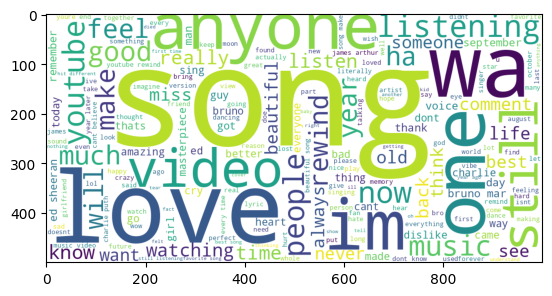

In [36]:
doc = []
stemmer = WordNetLemmatizer()
for comment in comments:

    # Lemmatization
    document = comment.split()
    document = [stemmer.lemmatize(word) for word in document]
    doc.extend(document)

wordcloud = " ".join(doc)
wordcloud = WordCloud(width = 1000, height = 500,background_color ='white',min_font_size = 10).generate(wordcloud)
plt.imshow(wordcloud)

In [37]:
nlp = spacy.load('en_core_web_sm')
nlp.add_pipe('spacytextblob')

def sentiment_analysis(comment):
  doc = nlp(comment)
  polarity = doc._.blob.polarity
  return "Positive" if polarity >= 0.2 else ("Negative" if polarity <= -0.2 else "Neutral")

comment_df3['sentiment'] = comment_df3['comment'].apply(lambda x: sentiment_analysis(x))
comment_df3['sentiment']

,sentiment
0,Neutral
1,Neutral
2,Positive
3,Positive
4,Neutral
...,...
19422,Neutral
19423,Neutral
19424,Positive
19425,Neutral


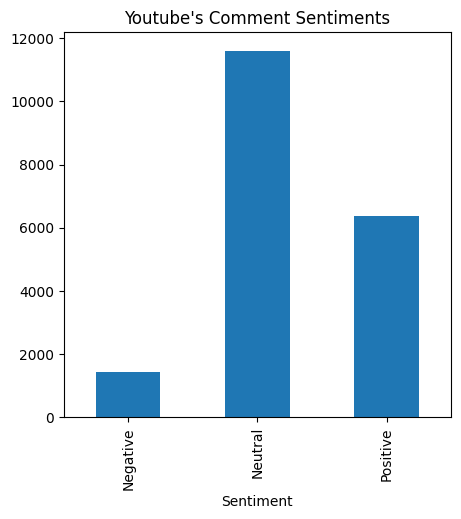

In [38]:
ax = comment_df3["sentiment"].value_counts().sort_index() \
    .plot(kind='bar',
          title='Youtube\'s Comment Sentiments',
          figsize=(5, 5))
ax.set_xlabel('Sentiment')
plt.show()

## Data Preprocessing

In [39]:
enc_maps = {
    "sentiment" : [{'col': "sentiment", 'mapping': {"Positive": 2, "Neutral": 1, "Negative": 0}}],
}

enc_map = enc_maps["sentiment"]
enc = OrdinalEncoder(mapping=enc_map)
comment_df3 = enc.fit_transform(comment_df3)

sentiments = comment_df3["sentiment"]
sentiments

,sentiment
0,1
1,1
2,2
3,2
4,1
...,...
19422,1
19423,1
19424,2
19425,1


In [40]:
doc = []
stemmer = WordNetLemmatizer()
for comment in comments:

    # Lemmatization
    document = comment.split()
    document = [stemmer.lemmatize(word) for word in document]
    document = ' '.join(document)
    doc.append(document)

doc

['dear ed sheeran',
 'the only person she wanted to talk about augustus water death wa augustus watersthis line made me cry',
 'thanks for being part of the tfios movie ed beautiful song john',
 'im surprised that this song isnt high up there this song is amazing',
 'you gave me forever within the numbered day',
 'the fault in our star is one of the most beautiful book ive ever read and this song is one of the most beautiful song ive ever heard',
 'am the only one who cry cause hell this song is beautiful',
 'my heart ache every time listen to this song',
 'this song make me cry so much the video just make me miss gu even more',
 'everything about the fault in our star is touching the book the film the song thank john green for this',
 'im cying over someone havent even met yet thats how powerful this song is',
 'dear stranger you have great taste in music see you again afteryrs',
 'hope everyone who read this comment get little infinity of their own somedayits the most we can hope for

In [41]:
# Use only Tokenizer for consistent text processing
tokenizer = Tokenizer(num_words=10000, oov_token='<OOV>')
tokenizer.fit_on_texts(doc)
sequences = tokenizer.texts_to_sequences(doc)

sequences

[[457, 70, 150],
 [3,
  85,
  183,
  74,
  343,
  5,
  324,
  79,
  1993,
  828,
  811,
  19,
  1993,
  4889,
  506,
  122,
  13,
  111],
 [306, 18, 241, 187, 12, 3, 1300, 359, 70, 69, 4, 954],
 [23, 1006, 15, 2, 4, 271, 519, 95, 91, 2, 4, 6, 136],
 [11, 400, 13, 252, 1489, 3, 3416, 77],
 [3,
  614,
  9,
  163,
  234,
  6,
  27,
  12,
  3,
  104,
  69,
  592,
  152,
  99,
  344,
  7,
  2,
  4,
  6,
  27,
  12,
  3,
  104,
  69,
  4,
  152,
  99,
  160],
 [98, 3, 85, 27, 16, 111, 315, 511, 2, 4, 6, 69],
 [10, 102, 1237, 87, 41, 78, 5, 2, 4],
 [2, 4, 59, 13, 111, 17, 66, 3, 33, 22, 59, 13, 94, 3417, 100, 108],
 [195,
  79,
  3,
  614,
  9,
  163,
  234,
  6,
  646,
  3,
  592,
  3,
  955,
  3,
  4,
  169,
  954,
  1618,
  18,
  2],
 [23, 4890, 179, 97, 464, 100, 410, 403, 157, 39, 751, 2, 4, 6],
 [457, 1161, 11, 42, 139, 498, 9, 48, 81, 11, 127, 2731],
 [175,
  153,
  16,
  344,
  2,
  89,
  65,
  284,
  1769,
  12,
  184,
  373,
  4891,
  3,
  104,
  37,
  46,
  175,
  18,
  9,
  2,
  1

In [42]:
# Pad sequences to ensure consistent input length
max_length = 200
X = pad_sequences(sequences, maxlen=max_length, padding='post', truncating='post')
X

array([[457,  70, 150, ...,   0,   0,   0],
       [  3,  85, 183, ...,   0,   0,   0],
       [306,  18, 241, ...,   0,   0,   0],
       ...,
       [  1,  65, 934, ...,   0,   0,   0],
       [ 23,   9, 366, ...,   0,   0,   0],
       [ 85,  62,  74, ...,   0,   0,   0]], dtype=int32)

## Data Splitting

In [43]:
# Split data (training: 70%, validation: 15%, testing: 15%)
X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size=0.15, random_state=40)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.17, random_state=40)

## Modelling

In [44]:
vocab_size = len(tokenizer.word_index) + 1 # melihat ukuran vocabulary
embedding_vector_length = 128

print(vocab_size)

13401


In [45]:
# BiLSTM Model

opt = tf.keras.optimizers.Adam(learning_rate=0.01, weight_decay=1e-4)
early_stopping = EarlyStopping(
    monitor="val_accuracy",
    min_delta=0,
    patience=0,
    verbose=0,
    mode="max",
    baseline=0.87,
    restore_best_weights=True,
    start_from_epoch=0,
)
model = Sequential()
model.add(Embedding(vocab_size, embedding_vector_length, input_length=max_length))
model.add(Dropout(0.5))
model.add(Bidirectional(LSTM(128)))
model.add(Dense(128, activation='tanh'))
model.add(Dropout(0.5))
model.add(Dense(3, activation='softmax'))

model.compile(optimizer=opt, metrics=['accuracy'], loss='sparse_categorical_crossentropy')

model.build(input_shape=(None, max_length))
model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ (None, 200, 128)       │     1,715,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 200, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, 256)            │       263,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,011,779 (7.67 MB)

 Trainable params: 2,011,779 (7.67 MB)

 Non-trainable params: 0 (0.00 B)

In [46]:
# Training
history = model.fit(X_train, y_train, epochs=50, validation_data=(X_val, y_val), callbacks=[early_stopping])

Epoch 1/50
429/429 ━━━━━━━━━━━━━━━━━━━━ 182s 418ms/step - accuracy: 0.7164 - loss: 0.7135 - val_accuracy: 0.9160 - val_loss: 0.2548
Epoch 2/50
429/429 ━━━━━━━━━━━━━━━━━━━━ 178s 415ms/step - accuracy: 0.9268 - loss: 0.2153 - val_accuracy: 0.9142 - val_loss: 0.2714


## Evaluation

In [47]:
print("BiLSTM, spacytextblob Labeling, 70/15/15 Dataset")
evaluate(model, X_train, y_train, "Training")
evaluate(model, X_val, y_val, "Validation")
evaluate(model, X_test, y_test, "Testing")

BiLSTM, spacytextblob Labeling, 70/15/15 Dataset
429/429 ━━━━━━━━━━━━━━━━━━━━ 42s 98ms/step - accuracy: 0.9351 - loss: 0.1849
Training Accuracy: 0.934
Training Loss: 0.188
88/88 ━━━━━━━━━━━━━━━━━━━━ 9s 97ms/step - accuracy: 0.9162 - loss: 0.2508
Validation Accuracy: 0.916
Validation Loss: 0.255
92/92 ━━━━━━━━━━━━━━━━━━━━ 9s 100ms/step - accuracy: 0.9141 - loss: 0.2642
Testing Accuracy: 0.917
Testing Loss: 0.250


In [48]:
inference(model, X_test)

92/92 ━━━━━━━━━━━━━━━━━━━━ 9s 99ms/step


,Actual,Prediction
0,1,1
1,2,2
2,1,1
3,1,1
4,1,2
...,...,...
2910,2,2
2911,2,2
2912,1,1
2913,2,2
